In [117]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 400)
import re


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

import time
import warnings
warnings.filterwarnings('ignore')

In [118]:
train_id = pd.read_csv("train_identity.csv")
train_tran = pd.read_csv("train_transaction.csv")

In [119]:
print(train_id.shape)
print(train_tran.shape)

(144233, 41)
(590540, 394)


In [120]:
train_id.sample(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
38586,3081635,-5.0,76658.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.000000,NotFound,52.0,-300.0,Found,Found,166.0,13.0,410.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 7,chrome 63.0,24.0,1920x1080,match_status:2,T,F,T,T,desktop,Windows
4420,3005382,-15.0,77007.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.000000,NotFound,52.0,-360.0,Found,Found,225.0,NaN,266.0,566.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 49.0,NaN,NaN,NaN,F,T,T,F,desktop,NaN
54627,3109823,-5.0,118480.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.000000,NotFound,52.0,NaN,Found,Found,225.0,NaN,266.0,638.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 63.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
52893,3105228,-5.0,92247.0,NaN,NaN,5.0,-13.0,NaN,NaN,0.0,-1.0,95.769997,NotFound,52.0,-300.0,New,NotFound,166.0,13.0,410.0,489.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 7,ie 11.0 for desktop,24.0,1280x1024,match_status:2,T,F,T,T,desktop,rv:11.0
32570,3070801,-40.0,218030.0,NaN,NaN,6.0,-15.0,NaN,NaN,NaN,NaN,100.000000,NotFound,18.0,NaN,New,NotFound,225.0,15.0,417.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 63.0 for android,NaN,NaN,NaN,F,F,T,T,mobile,ALE-L23 Build/HuaweiALE-L23


In [121]:
train_tran.sample(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
56006,3043006,0,1295316,75.000,R,9303,298.0,150.0,visa,226.0,debit,476.0,87.0,NaN,NaN,aol.com,aol.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,510.958344,0.958333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,53.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43717,3030717,0,1042884,100.000,H,15063,514.0,150.0,visa,226.0,credit,315.0,87.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

### <font color='red'>Memory Reduction</font>

In [122]:
# Memory Reduction
#%%time

def reduce_mem_usage2(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    
    return df

In [123]:
# #Merging Transaction & Identity datasets

# train=train_tran.merge(train_id,how='left',left_index=True,right_index=True)
# y_train=train['isFraud'].astype('uint8')
# print('Train shape',train.shape)

In [124]:
%%time
#Memory reduction for train dataset

reduce_mem_usage2(train_tran)
reduce_mem_usage2(train_id)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 487.16 MB
Decreased by 72.6%
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 10.02 MB
Decreased by 77.8%
Wall time: 3min 13s


In [125]:
#Collects memory garbage
import gc
gc.collect()

52

In [126]:
#Dropping y variable
y_train = train_tran.isFraud
train_tran = train_tran.drop('isFraud', axis=1)

In [127]:
y_train.to_csv('y_train.csv', index = None, header=True)

## <font color='red'>EDA</font>

Text(0.5, 1.0, 'Target variable count')

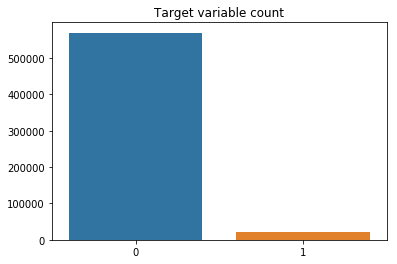

In [128]:
#Target Variable
x=y_train.value_counts().values
sns.barplot([0,1],x)
plt.title('Target variable count')

In [129]:
y_train.value_counts()/len(y_train) * 100

0    96.500999
1     3.499001
Name: isFraud, dtype: float64

The above analysis implies data imbalance which will be taken care in later part.

(array([2.30049e+05, 0.00000e+00, 0.00000e+00, 2.81003e+05, 0.00000e+00,
        0.00000e+00, 3.29500e+03, 0.00000e+00, 0.00000e+00, 1.20000e+02]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ],
       dtype=float16),
 <a list of 10 Patch objects>)

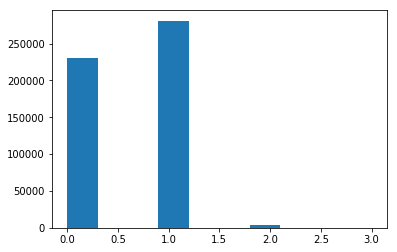

In [130]:
plt.hist(train_tran['V12'], bins = 10)

### <font color='red'>Exploring Missing Values</font>

In [131]:
# Finding columns with more than 60% missing values
drop = (train_tran.isna().sum()/len(train_tran) > 0.6)
drop.sum()
train_tran = train_tran.loc[:, ~drop]

In [132]:
train_tran.shape

(590540, 225)

In [133]:
train_tran.isna().sum()/len(train_tran) * 100

TransactionID      0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              1.512683
card3              0.265012
card4              0.267044
card5              0.721204
card6              0.266028
addr1             11.126427
addr2             11.126427
dist1             59.652352
P_emaildomain     15.994852
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D1                 0.214888
D2                47.549192
D3                44.514851
D4                28.604667
D5                52.467403
D10               12.873302
D11               47.293494
D15               15

## <font color='red'>Imputation</font>

#Imputing the features with less percentage [12%] of missingness & higher percentage with -1

In [134]:
#as the data type is float16 which is not supported by array elements & table columns in python, it has to be converted to float32
#Imputing Cards
train_tran['card2'] = train_tran['card2'].fillna(train_tran['card2'].astype(np.float32).mean())
train_tran['card3'] = train_tran['card3'].fillna(train_tran['card3'].astype(np.float32).mode().values[0])
train_tran['card4'] = train_tran['card4'].fillna(train_tran['card4'].mode()[0])
train_tran['card5'] = train_tran['card5'].fillna(train_tran['card5'].astype(np.float32).mode()[0])
train_tran['card6'] = train_tran['card6'].fillna(train_tran['card6'].mode()[0])

In [135]:
#Imputing address features
train_tran['addr1'] = train_tran['addr1'].fillna(train_tran['addr1'].astype(np.float32).mean())
train_tran['addr2'] = train_tran['addr2'].fillna(train_tran['addr2'].astype(np.float32).mode()[0])
train_tran['dist1'] = train_tran['dist1'].fillna(-1) #Imputing with -1
train_tran['P_emaildomain'] = train_tran['P_emaildomain'].cat.add_categories('-1').fillna('-1') # Add category & then impute with -1 for categorical columns


In [136]:
#Imputing D Features
train_tran['D10'] = train_tran['D10'].fillna(train_tran['D10'].astype(np.float32).mode()[0])
train_tran['D1'] = train_tran['D1'].fillna(train_tran['D1'].astype(np.float32).mode()[0])
train_tran['D2'] = train_tran['D2'].fillna(-1)
train_tran['D3'] = train_tran['D3'].fillna(-1)
train_tran['D4'] = train_tran['D4'].fillna(-1)
train_tran['D5'] = train_tran['D5'].fillna(-1)
train_tran['D11'] = train_tran['D11'].fillna(-1)
train_tran['D15'] = train_tran['D15'].fillna(-1)

In [137]:
#Imputing M Features
train_tran['M1'] = train_tran['M1'].cat.add_categories('-1').fillna('-1')
train_tran['M2'] = train_tran['M2'].cat.add_categories('-1').fillna('-1')
train_tran['M3'] = train_tran['M3'].cat.add_categories('-1').fillna('-1')
train_tran['M4'] = train_tran['M4'].cat.add_categories('-1').fillna('-1')
train_tran['M5'] = train_tran['M5'].cat.add_categories('-1').fillna('-1')
train_tran['M6'] = train_tran['M6'].cat.add_categories('-1').fillna('-1')
train_tran['M7'] = train_tran['M7'].cat.add_categories('-1').fillna('-1')
train_tran['M8'] = train_tran['M8'].cat.add_categories('-1').fillna('-1')
train_tran['M9'] = train_tran['M9'].cat.add_categories('-1').fillna('-1')

In [138]:
# train_tran['D15'].value_counts()#To check if we can impute with mean or mode

In [139]:
# train_tran['M9'].isna().sum()#To check if there are still any null values

In [140]:
# train_tran['D3'].dtype

In [141]:
#Check Point

train_tran.isna().sum()/len(train_tran) * 100

TransactionID      0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              0.000000
card3              0.000000
card4              0.000000
card5              0.000000
card6              0.000000
addr1              0.000000
addr2              0.000000
dist1              0.000000
P_emaildomain      0.000000
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D1                 0.000000
D2                 0.000000
D3                 0.000000
D4                 0.000000
D5                 0.000000
D10                0.000000
D11                0.000000
D15                0

In [142]:
#Though below 'V' features have missingness less than 12%, still mean & mode can't be applied:
train_tran['V282'] = train_tran['V282'].fillna('-1')
train_tran['V283'] = train_tran['V283'].fillna('-1')
train_tran['V285'] = train_tran['V285'].fillna('-1')
train_tran['V302'] = train_tran['V302'].fillna('-1')
train_tran['V303'] = train_tran['V303'].fillna('-1')
train_tran['V304'] = train_tran['V304'].fillna('-1')

In [143]:
train_tran.isna().sum()/len(train_tran) * 100

TransactionID      0.000000
TransactionDT      0.000000
TransactionAmt     0.000000
ProductCD          0.000000
card1              0.000000
card2              0.000000
card3              0.000000
card4              0.000000
card5              0.000000
card6              0.000000
addr1              0.000000
addr2              0.000000
dist1              0.000000
P_emaildomain      0.000000
C1                 0.000000
C2                 0.000000
C3                 0.000000
C4                 0.000000
C5                 0.000000
C6                 0.000000
C7                 0.000000
C8                 0.000000
C9                 0.000000
C10                0.000000
C11                0.000000
C12                0.000000
C13                0.000000
C14                0.000000
D1                 0.000000
D2                 0.000000
D3                 0.000000
D4                 0.000000
D5                 0.000000
D10                0.000000
D11                0.000000
D15                0

In [144]:
v_smiss = [col for col in train_tran.columns if ((train_tran[col].isna().sum()/len(train_tran) * 100) < 12.0 and ('V' in col))]
v_smiss = train_tran[v_smiss]
v_lmiss = [col for col in train_tran.columns if ((train_tran[col].isna().sum()/len(train_tran) * 100) > 12.0 and ('V' in col))]
v_lmiss = train_tran[v_lmiss]

In [145]:
print(v_smiss.shape)
print(v_lmiss.shape)

(590540, 86)
(590540, 94)


In [146]:
#Impute all the 'V' columns with less than 12% missingness with mode

for col in v_smiss:
    v_smiss[col] = v_smiss[col].fillna(v_smiss[col].astype(np.float32).mode()[0])

In [147]:
#Impute all the 'V' columns with more than 12% missingness with -1

for col in v_lmiss:
    v_lmiss[col] = v_lmiss[col].fillna('-1')

In [148]:
#Combining all imputed 'V' columns
V_col = pd.concat([v_lmiss,v_smiss], axis=1)


In [149]:
#Dropping all 'V' columns from train_tran & combining with imputed 'V' columns
train_tran = train_tran[train_tran.columns.drop(list(train_tran.filter(regex='V')))]
train_tran_imputed = pd.concat([train_tran,V_col], axis=1)

In [150]:
train_tran_imputed.shape

(590540, 225)

In [151]:
train_tran_imputed.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,86400,68.5,W,13926,362.5,150.0,discover,142.0,credit,315.0,87.0,19.0,-1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-1.0,13.0,-1.0,-1.0,13.0,13.0,0.0,T,T,T,M2,F,T,-1,-1,-1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,-1.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,-1,-1,-1,M0,T,T,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,1,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,315.0,315.0,T,T,T,M0,F,F,F,F,F,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,-1.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,-1.0,111.0,-1,-1,-1,M0,T,F,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,0,0,1,1,1,0,0,0,0,0,0,1.0,48.0,28.0,0.0,10.0,4.0,1.0,38.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,50.0,1758.0,925.0,0.0,354.0,135.0,50.0,1404.0,790.0,0.0,0.0,0.0,1.0,28.0,0.0,0,0,0.0,10,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0

In [152]:
train_tran_imputed.isna().sum() # Checkpoint

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
dist1             0
P_emaildomain     0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
D1                0
D2                0
D3                0
D4                0
D5                0
D10               0
D11               0
D15               0
M1                0
M2                0
M3                0
M4                0
M5                0
M6                0
M7                0
M8                0
M9                0
V1                0
V2                0
V3                0
V4                0
V5                0


#Imputing Identity df

In [153]:
#Imputing train_id
drop = (train_id.isna().sum()/len(train_id) * 100 > 68.0)
drop.sum()
train_id = train_id.loc[:, ~drop]

In [154]:
train_id.shape

(144233, 31)

In [155]:
train_id.isna().sum()/len(train_id) * 100

TransactionID     0.000000
id_01             0.000000
id_02             2.330257
id_03            54.016071
id_04            54.016071
id_05             5.108401
id_06             5.108401
id_09            48.052110
id_10            48.052110
id_11             2.256765
id_12             0.000000
id_13            11.726165
id_14            44.503685
id_15             2.251912
id_16            10.325654
id_17             3.372321
id_19             3.407681
id_20             3.447200
id_28             2.256765
id_29             2.256765
id_30            46.222432
id_31             2.739318
id_32            46.207872
id_33            49.187079
id_34            46.056034
id_35             2.251912
id_36             2.251912
id_37             2.251912
id_38             2.251912
DeviceType        2.373243
DeviceInfo       17.726179
dtype: float64

In [156]:
# train_id['id_03'].value_counts()

In [157]:
# train_id['id_03'].isna().sum()

In [158]:
# train_id['DeviceInfo'].dtype

In [159]:
#Imputing columns with less percentage of missingness
train_id['id_02'] = train_id['id_02'].fillna(round(train_id['id_02'].mean(),0))
train_id['id_05'] = train_id['id_05'].fillna(train_id['id_05'].mode()[0])
train_id['id_06'] = train_id['id_06'].fillna(train_id['id_06'].mode()[0])
train_id['id_11'] = train_id['id_11'].fillna(train_id['id_11'].mode()[0])
train_id['id_13'] = train_id['id_13'].fillna(round(train_id['id_13'].astype(np.float32).mean(),0))
train_id['id_15'] = train_id['id_15'].cat.add_categories('-1').fillna('-1')
train_id['id_16'] = train_id['id_16'].cat.add_categories('-1').fillna('-1')
train_id['id_17'] = train_id['id_17'].fillna('-1')
train_id['id_19'] = train_id['id_19'].fillna(round(train_id['id_19'].astype(np.float32).mean(),0))
train_id['id_20'] = train_id['id_20'].fillna(round(train_id['id_20'].astype(np.float32).mean(),0))
train_id['id_28'] = train_id['id_28'].cat.add_categories('-1').fillna('-1')
train_id['id_29'] = train_id['id_29'].cat.add_categories('-1').fillna('-1')
train_id['id_31'] = train_id['id_31'].cat.add_categories('-1').fillna('-1')
train_id['id_35'] = train_id['id_35'].cat.add_categories('-1').fillna('-1')
train_id['id_36'] = train_id['id_36'].cat.add_categories('-1').fillna('-1')
train_id['id_37'] = train_id['id_37'].cat.add_categories('-1').fillna('-1')
train_id['id_38'] = train_id['id_38'].cat.add_categories('-1').fillna('-1')
train_id['DeviceType'] = train_id['DeviceType'].cat.add_categories('-1').fillna('-1')






In [160]:
#Imputing columns with higher percentage of missingness
train_id['id_03'] = train_id['id_03'].fillna('-1')
train_id['id_04'] = train_id['id_03'].fillna('-1')
train_id['id_09'] = train_id['id_03'].fillna('-1')
train_id['id_10'] = train_id['id_03'].fillna('-1')
train_id['id_14'] = train_id['id_14'].fillna('-1')
train_id['id_30'] = train_id['id_30'].cat.add_categories('-1').fillna('-1')
train_id['id_32'] = train_id['id_32'].fillna('-1')
train_id['id_33'] = train_id['id_33'].cat.add_categories('-1').fillna('-1')
train_id['id_34'] = train_id['id_34'].cat.add_categories('-1').fillna('-1')
train_id['DeviceInfo'] = train_id['DeviceInfo'].cat.add_categories('-1').fillna('-1')

In [161]:
# Checkpoint for Identity df
train_id.isna().sum()/len(train_id) * 100

TransactionID    0.0
id_01            0.0
id_02            0.0
id_03            0.0
id_04            0.0
id_05            0.0
id_06            0.0
id_09            0.0
id_10            0.0
id_11            0.0
id_12            0.0
id_13            0.0
id_14            0.0
id_15            0.0
id_16            0.0
id_17            0.0
id_19            0.0
id_20            0.0
id_28            0.0
id_29            0.0
id_30            0.0
id_31            0.0
id_32            0.0
id_33            0.0
id_34            0.0
id_35            0.0
id_36            0.0
id_37            0.0
id_38            0.0
DeviceType       0.0
DeviceInfo       0.0
dtype: float64

In [162]:
%%time
train_tran_imputed.to_csv('train_tran_imputed.csv', index = None, header=True)
train_id.to_csv('train_id_imputed.csv', index = None, header=True)

Wall time: 2min 28s


In [165]:
gc.collect()

20